In [1]:
from datetime import datetime, timedelta
import numpy as np

import matplotlib
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import matplotlib.patches as mpatch
import matplotlib.ticker as mticker
from matplotlib import gridspec

import heliopy.data.spice as spicedata
import heliopy.spice as spice

import sunpy.map
from sunpy.coordinates import frames


import pfsspy

import astropy.units as u
import astropy.constants as const
import astropy.coordinates as coord
from astropy.io import fits

import helpers

matplotlib.rcParams['axes.titlesize'] = 14
matplotlib.rcParams['axes.labelsize'] = 14
matplotlib.rcParams['figure.titlesize'] = 14
matplotlib.rcParams['xtick.labelsize'] = 12
matplotlib.rcParams['ytick.labelsize'] = 12

ModuleNotFoundError: No module named 'numpy.core._multiarray_umath'

In [2]:
helpers.download_gong_maps()

Generate PSP trajectory
---

In [3]:
for kernel in ['psp', 'planet_trajectories', 'planet_orientations', 'psp_pred']:
    k = spicedata.get_kernel(kernel)
    spice.furnish(k)
    
psp = spice.Trajectory('SPP')
# Create list of times
starttime = datetime(2018, 10, 27)
endtime = datetime(2018, 11, 30)
times = []
while starttime < endtime:
    times.append(starttime)
    starttime += timedelta(hours=2)
    
psp.generate_positions(times, 'Sun', 'IAU_SUN')
psp.change_units(u.au)
psp_coord = coord.SkyCoord(x=psp.x, y=psp.y, z=psp.z, frame=frames.HeliographicCarrington,
                               representation_type='cartesian')
psp_coord.representation_type = 'spherical'

Project trajectory onto source surface, correcting for solar rotation
---

In [4]:
omega_sun = 14.713 * u.deg / u.d
vsw = 360 * u.km / u.s
def delta_long(r):
    return omega_sun * (r - 2.5 * const.R_sun) / vsw

psp_solar_lon = psp_coord.lon + delta_long(psp_coord.radius)
psp_solar_surface = coord.SkyCoord(radius=psp_coord.radius,
                                   lat=psp_coord.lat,
                                   lon=psp_solar_lon, frame=frames.HeliographicCarrington,
                                   representation_type='spherical')

Import GONG magnetogram data
---

Function to get $B_{r}$ from a GONG magnetogram map

In [5]:
def extract_br(m):
    br = m.data
    br = br - np.nanmean(br)
    # GONG maps have their LH edge at -180deg, so roll to get it at 0deg
    br = np.roll(br, m.meta['CRVAL1'] + 180, axis=1)
    return br

Get data for map closest to perihelion

In [6]:
gong_map = sunpy.map.Map('mrzqs181111t1104c2210_094.fits')
br = extract_br(gong_map)

Set up PFSS input and calculate PFSS solution
---

Calculate solution for perihelion map

In [7]:
nr = 60
rss = 2.5
peri_input = pfsspy.Input(br, nr, rss)
peri_output = pfsspy.pfss(peri_input)

Calculate solutions for all other maps. These are used later to asses the variability of the HCS over the perihelion time interval

In [8]:
map_fnames = helpers.gong_map_fnames()
outputs = []
for m in map_fnames:
    print(f'Processing {m}')
    m = sunpy.map.Map(m)
    br = extract_br(m)
    inp = pfsspy.Input(br, nr, rss)
    outputs.append(pfsspy.pfss(inp))

Processing mrzqs190325t0904c2215_130.fits
Processing mrzqs181111t1104c2210_094.fits


Trace field lines using perihelion map
---

In [9]:
flines = []
psp_solar_surface.representation_type = 'cartesian'
for i in range(0, len(psp_solar_surface.x)):
    seed = np.array([psp_solar_surface.x[i].value,
                      psp_solar_surface.y[i].value,
                      psp_solar_surface.z[i].value])
    seed = seed * 2.499 / np.linalg.norm(seed)
    fline = peri_output.trace(seed, atol=1e-6)
    flines.append(fline)

Calculate field line polarities and expansion factors
---

In [10]:
polarities = np.array([fline.polarity for fline in flines], dtype=float)
polarities[polarities == 0] = np.nan

In [11]:
expansion_factors = np.array([fline.expansion_factor for fline in flines])
expansion_factors[expansion_factors == None] = np.nan

### Get STEREO EUVI Image

In [12]:
## Read SECHHI's synoptic map using astropy:
hdul = fits.open('cmeuA171sid319cr2210C0id33011.fts')
header = hdul[0].header

## The header needs a little editing:
del header['DETECTOR']
header['cdelt1'] = 0.125
header['cdelt2'] = 0.0013986
header['CRPIX1'] = 1
header['CRPIX2'] = 1440//2 - 1
header['CUNIT1'] = 'degree'
header['CUNIT2'] = 'degree'

## Plot this map with the right units:
syn_map = sunpy.map.Map(hdul[0].data,header)

# Define grid
grid_euvi_x = np.linspace(0,360,syn_map.data.shape[1])
grid_euvi_y = np.linspace(-1,1,syn_map.data.shape[0])

#fig = plt.figure(figsize=(13, 6))
#axes = plt.subplot(projection=syn_map)
# Plot the image
#im = syn_map.plot(cmap='sdoaia171',vmin=0,vmax = 0.2*np.nanmax(syn_map.data),
#                 title='SECCHI/AIA-171 From '+header['DATEOBS1']+'  to  '+header['DATEOBS2'])
#y = axes.coords[1]; y.set_axislabel(r"Latitude [cos($\theta$)]")

Plot results
---

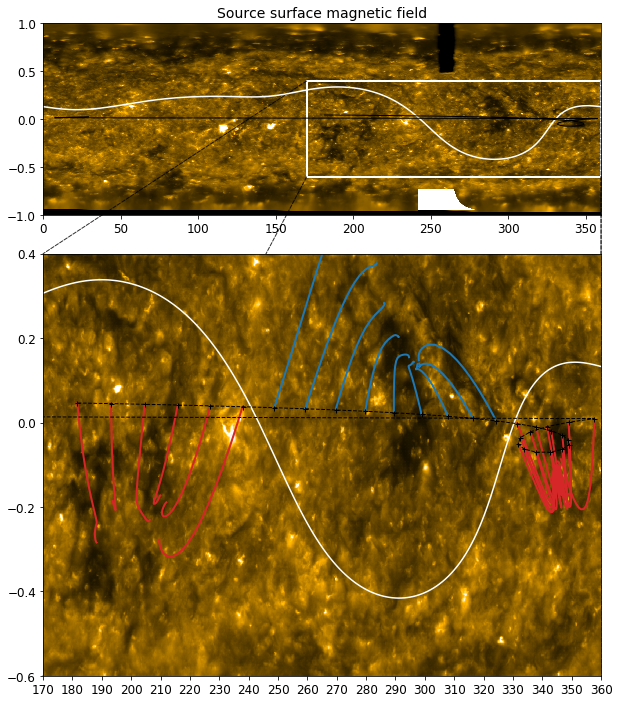

In [13]:
### psp_solar_surface.representation_type = 'spherical'
fig = plt.figure(figsize=(10,12))
gs = gridspec.GridSpec(3, 1)
ax1 = plt.subplot(gs[0])
ax2 = plt.subplot(gs[1:])

for ax in (ax1, ax2):
    ax.pcolormesh(grid_euvi_x,grid_euvi_y,syn_map.data,cmap='sdoaia171',vmin=0,vmax = 0.2*np.nanmax(syn_map.data),alpha=0.5)
    #mesh = pfsspy.plot.radial_cut(
    #peri_output.grid.pg, peri_output.grid.sg, peri_output.source_surface_br, ax)
    #mesh = peri_output.plot_source_surface(ax)
    peri_output.plot_pil(ax, colors='white', linestyles='-')
skip = 12
ax=ax2
for fline in flines[::skip]:
    color = {-1: 'tab:red', 1: 'tab:blue'}.get(fline.polarity)
    fline.representation_type = 'spherical'
    # Plot field line
    ax.plot(fline.lon, np.sin(fline.lat), color=color, linewidth=2.0, alpha=1.0)

psp_solar_surface.representation_type= 'spherical'    
ax.plot(psp_solar_surface.lon[::skip],
        np.sin(psp_solar_surface.lat[::skip]),
        color='black', marker='+', lw=1, linestyle='--', ms=5)

left, right = 170, 360
bottom, top = -0.6, 0.4
ax.set_xlim(left, right)
ax.set_ylim(bottom, top)

# Add connection lines between axes
for lims in ((left, top), (right, top), (left, bottom), (right, bottom)):
    con = mpatch.ConnectionPatch(xyA=lims, xyB=lims,
                          coordsA='data', coordsB='data',
                          axesA=ax1, axesB=ax2,
                          shrinkB=0, linestyle='--', alpha=0.8)
    ax1.add_artist(con)
    
ax.xaxis.set_major_locator(mticker.MultipleLocator(10))

ax = ax1

# Plot PSP trajectory
ax.plot(psp_solar_surface.lon[::skip],
    np.sin(psp_solar_surface.lat[::skip]),
    color='black', lw=1, linestyle='-')


# Add rectangle for zoomed box
ax.add_patch(mpatch.Rectangle((left, bottom),
                              right - left,
                              top - bottom, facecolor='none',
                              linewidth=2,edgecolor='white'))

ax.set_title('Source surface magnetic field')
   
fig.savefig('fline_mapping.png', bbox_inches='tight')


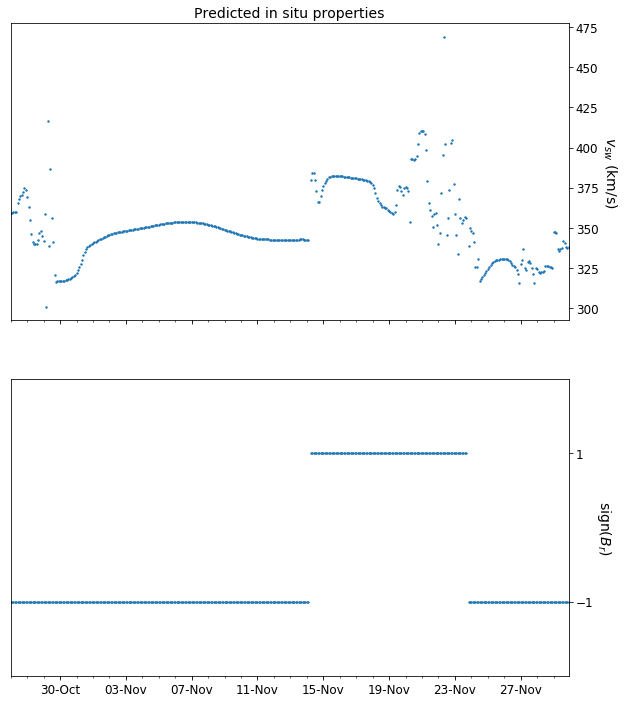

In [14]:
fig, axs = plt.subplots(nrows=2, figsize=(10, 12), sharex=True)

ax = axs[0]
ax.scatter(psp.times, 267.5 + 410 / (expansion_factors**(0.4)), s=2)
ax.set_title('Predicted in situ properties')
ax.set_ylabel('$v_{sw}$ (km/s)', rotation=-90, labelpad=20)

ax = axs[1]
ax.scatter(psp.times, polarities, s=2)
ax.set_ylabel('sign$(B_{r})$', rotation=-90, labelpad=20)
ax.set_ylim(-2, 2)

ax.yaxis.set_major_locator(mticker.FixedLocator([-1, 1]))
ax.xaxis.set_major_locator(mdates.DayLocator(interval=4))
ax.xaxis.set_minor_locator(mdates.DayLocator(interval=1))
ax.xaxis.set_major_formatter(mdates.DateFormatter("%d-%b"))
ax.set_xlim(psp.times[0], psp.times[-1])

for ax in axs:
    ax.yaxis.tick_right()
    ax.yaxis.set_label_position("right")

fig.savefig('tseries.pdf', bbox_inches='tight')

# Synoptic EUVI/AIA Map

/home/samuel_badman/anaconda3/lib/python3.7/site-packages/sunpy/map/mapbase.py:298: Warning: Missing metadata for observation time: setting observation time to current time
  w2.wcs.dateobs = self.date.isoformat()
/home/samuel_badman/anaconda3/lib/python3.7/site-packages/sunpy/map/mapbase.py:673: Warning: Missing metadata for heliographic latitude: assuming Earth-based observer
  return SkyCoord(lat=self.heliographic_latitude,
/home/samuel_badman/anaconda3/lib/python3.7/site-packages/sunpy/map/mapbase.py:674: Warning: Missing metadata for heliographic longitude: assuming longitude of 0 degrees
  lon=self.heliographic_longitude,
/home/samuel_badman/anaconda3/lib/python3.7/site-packages/sunpy/map/mapbase.py:675: Warning: Missing metadata for Sun-spacecraft separation: assuming Sun-Earth distance
  radius=self.dsun,
/home/samuel_badman/anaconda3/lib/python3.7/site-packages/matplotlib/contour.py:1000: UserWarning: The following kwargs were not used by contour: 'color'
  s)


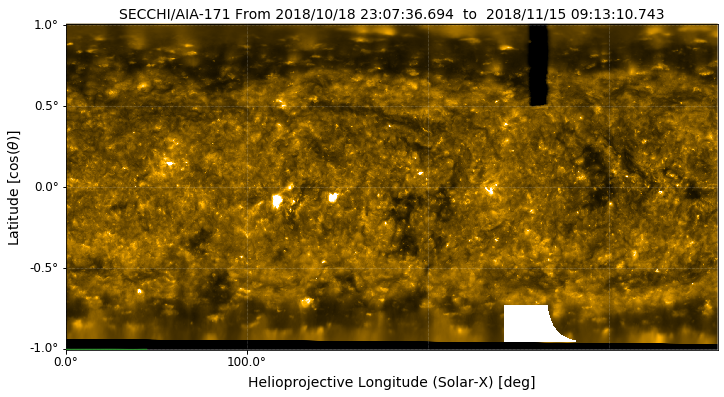

In [15]:
## Read SECHHI's synoptic map using astropy:
from astropy.io import fits
hdul = fits.open('cmeuA171sid319cr2210C0id33011.fts')
header = hdul[0].header

## The header needs a little editing:
del header['DETECTOR']
header['cdelt1'] = 0.125
header['cdelt2'] = 0.0013986
header['CRPIX1'] = 1
header['CRPIX2'] = 1440//2 - 1
header['CUNIT1'] = 'degree'
header['CUNIT2'] = 'degree'

## Plot this map with the right units:
syn_map = sunpy.map.Map(hdul[0].data,header)

fig = plt.figure(figsize=(13, 6))
axes = plt.subplot(projection=syn_map)
# Plot the image
im = syn_map.plot(cmap='sdoaia171',vmin=0,vmax = 0.2*np.nanmax(syn_map.data),
                 title='SECCHI/AIA-171 From '+header['DATEOBS1']+'  to  '+header['DATEOBS2'])
y = axes.coords[1]; y.set_axislabel(r"Latitude [cos($\theta$)]")
peri_output.plot_pil(axes,colors='tab:green', linestyles='-',color="white")


### Extracting Footpoints from the fline objects

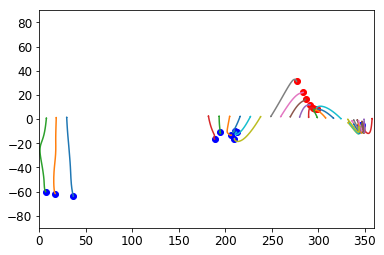

In [16]:
plt.xlim([0,360])
plt.ylim([-90,90])
for fline in flines[::12] : 
    # fline are a subclass of astropy.coordinates.SkyCoords
    # They are stored in cartesian coordinates and must be converted
    # to spherical with the following :
    fline.representation_type = 'spherical'
    plt.plot(fline.lon,fline.lat)
    # The data can then be accessed as np.array(fline.lon) for longitude values in degrees
    # and np.array(fline.lat) for latitude values in degrees
    # The ordering of the points from spacecraft to footpoint is reveresed if the polarity
    # is reversed. If the polarity is -1 then the footpoint is the last coordinate in each array,
    # if the polarity is +1 then the footpoint is the first coordinate in each array
    index = {-1: -1, 1: 0}.get(fline.polarity)
    color = {-1: 'blue', 1: 'red'}.get(fline.polarity)
    plt.scatter(fline.lon[index],fline.lat[index],color=color)

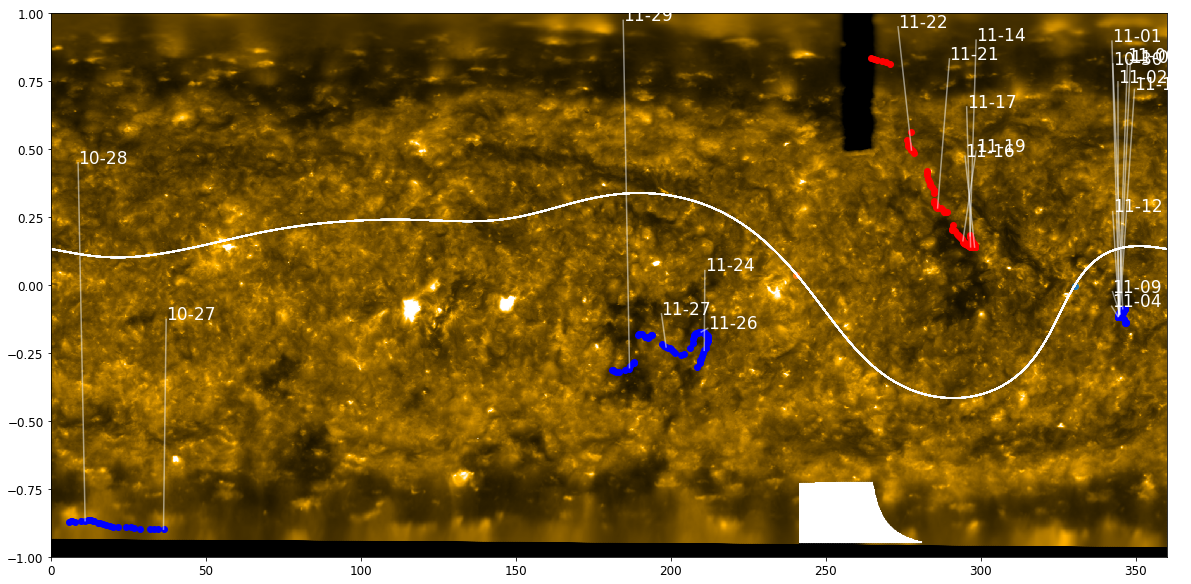

In [17]:
# Store datetime, lon and lat of each footpoint in arrays
timestamps = []
lons = []
lats= []
plt.figure(figsize=(20,10))
ax=plt.subplot(111)
plt.xlim([0,360])
plt.ylim([-1,1])
plt.pcolormesh(grid_euvi_x,grid_euvi_y,syn_map.data,cmap='sdoaia171',vmin=0,vmax = 0.2*np.nanmax(syn_map.data),alpha=0.5)
for fline,i in zip(flines,range(len(flines))) :
    fline.representation_type = 'spherical'
    index = {-1: -1, 0 : 0, 1: 0}.get(fline.polarity)
    color = {-1: 'blue', 1: 'red'}.get(fline.polarity)
    lons.append(np.array(fline.lon)[index])
    lats.append(np.array(fline.lat)[index])
    timestamps.append((times[i] - datetime(1970,1,1)).total_seconds())
    plt.scatter(lons[-1],np.sin(np.radians(lats[-1])),color=color)
    peri_output.plot_pil(ax, colors='white', linestyles='-')
    if (i/20) == (i//20) : 
        rand1 = np.random.random()*(1-np.sin(np.radians(lats[-1])))
        rand2 = np.random.random()*10-5
        plt.text(lons[-1]+rand2,np.sin(np.radians(lats[-1]))+rand1,str(times[i])[5:10],fontsize=17,color='white')
        plt.plot([lons[-1],lons[-1]+rand2],[np.sin(np.radians(lats[-1])),np.sin(np.radians(lats[-1]))+rand1],color='white',alpha=0.5)

In [18]:
# Create dataframe and save as CSV file
import pandas as pd
footpoint_dict = {'Unix Timestamp [s]': timestamps, 'Carrington Longitudes [deg]': lons, 'Carrington Latitudes [deg]':lats}
footpoint_df = pd.DataFrame(data=footpoint_dict)
footpoint_df.to_csv(r'./PSP_magfootpoints_perihelion1.csv', header=None, index=None, sep=' ', mode='a')